# Imports

In [1]:
import os
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import wandb
import auraloss
import collections
from tqdm import tqdm
import pretty_midi
import matplotlib.pyplot as plt
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
print(torch.cuda.is_available())
import plotly.graph_objects as go
from torch.optim import lr_scheduler
from IPython.display import Audio
from torchaudio.transforms import Fade
import musdb
import museval
import gc

True


In [2]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import subprocess
import wandb
import auraloss
import collections
from tqdm import tqdm
import librosa
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
print(torch.cuda.is_available())
from torch.optim import lr_scheduler
import pretty_midi
from typing import Optional, Tuple


True


In [3]:
class Track:
    def __init__(self, name, midi_path, drum_path, mix_path):
        self.name = name
        self.midi_path = midi_path
        self.drum_path = drum_path
        self.mix_path = mix_path
        self.targets = {'drums': '', 'bass': ''}
        self.rate = 44100
        self.subset = 'test'

# Set Seeds

In [4]:
seed_value = 3407
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision('high')

In [5]:
mix_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/full_mix/'
mixes = os.listdir(mix_folder)
mixes = [mix_folder + m for m in mixes]

drum_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/drum_only/'
drum = os.listdir(drum_folder)
drum = [drum_folder + d for d in drum]

beats_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/beats/'
beats = os.listdir(beats_folder)
beats = [beats_folder + b for b in beats]#

class_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/'
classes = os.listdir(class_folder)
classes = [class_folder + c for c in classes]

midi_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/midi/'
midis = os.listdir(midi_folder)
midis = [midi_folder + m for m in midis]

In [6]:
all_tracks = []
for idx, val in tqdm(enumerate(classes)):

    name = val.replace('D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/', '')
    name = name.replace('_subclass.txt', '')

    t = Track(name, midis[idx], drum[idx], mixes[idx])
    all_tracks.append(t)

23it [00:00, ?it/s]


# Construct Teh Datas

In [7]:
def turn_transcription_into_roll(transcription, frames):
    # Determine your sampling frequency (frames per second)
    fs = 44100
    
    piano_roll_length = int(frames)
    
    # Initialize the piano roll array
    piano_roll = np.zeros((64, piano_roll_length))
    
    # Fill in the piano roll array
    for note in transcription.instruments[0].notes:
        # Convert start and end times to frame indices
        start_frame = int(np.floor(note.start * fs))
        end_frame = int(np.ceil(note.end * fs))
        
        # Set the corresponding frames to 1 (or note.velocity for a velocity-sensitive representation)
        piano_roll[note.pitch, start_frame:end_frame] = 1  # Or use note.velocity
        
    roll = np.vstack([piano_roll[35:36, :], piano_roll[38:39, :], piano_roll[42:43, :], piano_roll[47:48, :], piano_roll[49:50, :]])
    return roll

# model

In [8]:

class ConvBlock(torch.nn.Module):
    """1D Convolutional block.

    Args:
        io_channels (int): The number of input/output channels, <B, Sc>
        hidden_channels (int): The number of channels in the internal layers, <H>.
        kernel_size (int): The convolution kernel size of the middle layer, <P>.
        padding (int): Padding value of the convolution in the middle layer.
        dilation (int, optional): Dilation value of the convolution in the middle layer.
        no_redisual (bool, optional): Disable residual block/output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
        no_residual: bool = False,
    ):
        super().__init__()

        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            torch.nn.Conv1d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
        )

        self.res_out = (
            None
            if no_residual
            else torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)
        )
        self.skip_out = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)

    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        if self.res_out is None:
            residual = None
        else:
            residual = self.res_out(feature)
        skip_out = self.skip_out(feature)
        return residual, skip_out




# In[12]:


class MaskGenerator(torch.nn.Module):
    """TCN (Temporal Convolution Network) Separation Module

    Generates masks for separation.

    Args:
        input_dim (int): Input feature dimension, <N>.
        num_sources (int): The number of sources to separate.
        kernel_size (int): The convolution kernel size of conv blocks, <P>.
        num_featrs (int): Input/output feature dimenstion of conv blocks, <B, Sc>.
        num_hidden (int): Intermediate feature dimention of conv blocks, <H>
        num_layers (int): The number of conv blocks in one stack, <X>.
        num_stacks (int): The number of conv block stacks, <R>.
        msk_activate (str): The activation function of the mask output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        input_dim: int,
        num_sources: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
        msk_activate: str,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.num_sources = num_sources

        self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
        self.input_conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=num_feats, kernel_size=1)

        self.receptive_field = 0
        self.conv_layers = torch.nn.ModuleList([])
        for s in range(num_stacks):
            for l in range(num_layers):
                multi = 2**l
                self.conv_layers.append(
                    ConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=multi,
                        padding=multi,
                        # The last ConvBlock does not need residual
                        no_residual=(l == (num_layers - 1) and s == (num_stacks - 1)),
                    )
                )
                self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * multi
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(
            in_channels=num_feats,
            out_channels=input_dim * num_sources,
            kernel_size=1,
        )
        if msk_activate == "sigmoid":
            self.mask_activate = torch.nn.Sigmoid()
        elif msk_activate == "relu":
            self.mask_activate = torch.nn.ReLU()
        elif msk_activate == "prelu":
            self.mask_activate = torch.nn.PReLU()
        else:
            raise ValueError(f"Unsupported activation {msk_activate}")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Generate separation mask.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, features, frames]

        Returns:
            Tensor: shape [batch, num_sources, features, frames]
        """
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            if residual is not None:  # the last conv layer does not produce residual
                feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.mask_activate(output)
        return output.view(batch_size, self.num_sources, self.input_dim, -1)


# In[13]:


class ConvTasNet(torch.nn.Module):
    """Conv-TasNet architecture introduced in
    *Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation*
    :cite:`Luo_2019`.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.

    See Also:
        * :class:`torchaudio.pipelines.SourceSeparationBundle`: Source separation pipeline with pre-trained models.

    Args:
        num_sources (int, optional): The number of sources to split.
        enc_kernel_size (int, optional): The convolution kernel size of the encoder/decoder, <L>.
        enc_num_feats (int, optional): The feature dimensions passed to mask generator, <N>.
        msk_kernel_size (int, optional): The convolution kernel size of the mask generator, <P>.
        msk_num_feats (int, optional): The input/output feature dimension of conv block in the mask generator, <B, Sc>.
        msk_num_hidden_feats (int, optional): The internal feature dimension of conv block of the mask generator, <H>.
        msk_num_layers (int, optional): The number of layers in one conv block of the mask generator, <X>.
        msk_num_stacks (int, optional): The numbr of conv blocks of the mask generator, <R>.
        msk_activate (str, optional): The activation function of the mask output (Default: ``sigmoid``).
    """

    def __init__(
        self,
        num_sources: int = 2,
        # encoder/decoder parameters
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        # mask generator parameters
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 8,
        msk_num_stacks: int = 3,
        msk_activate: str = "sigmoid",
    ):
        super().__init__()

        self.num_sources = num_sources
        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = torch.nn.Conv1d(
            in_channels=7,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
        self.mask_generator = MaskGenerator(
            input_dim=enc_num_feats,
            num_sources=num_sources,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks,
            msk_activate=msk_activate,
        )
        self.decoder = torch.nn.ConvTranspose1d(
            in_channels=enc_num_feats,
            out_channels=2,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )

    def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """Pad input Tensor so that the end of the input tensor corresponds with

        1. (if kernel size is odd) the center of the last convolution kernel
        or 2. (if kernel size is even) the end of the first half of the last convolution kernel

        Assumption:
            The resulting Tensor will be padded with the size of stride (== kernel_width // 2)
            on the both ends in Conv1D

        |<--- k_1 --->|
        |      |            |<-- k_n-1 -->|
        |      |                  |  |<--- k_n --->|
        |      |                  |         |      |
        |      |                  |         |      |
        |      v                  v         v      |
        |<---->|<--- input signal --->|<--->|<---->|
         stride                         PAD  stride

        Args:
            input (torch.Tensor): 3D Tensor with shape (batch_size, channels==1, frames)

        Returns:
            Tensor: Padded Tensor
            int: Number of paddings performed
        """
        batch_size, num_channels, num_frames = input.shape
        is_odd = self.enc_kernel_size % 2
        num_strides = (num_frames - is_odd) // self.enc_stride
        num_remainings = num_frames - (is_odd + num_strides * self.enc_stride)
        if num_remainings == 0:
            return input, 0

        num_paddings = self.enc_stride - num_remainings
        pad = torch.zeros(
            batch_size,
            num_channels,
            num_paddings,
            dtype=input.dtype,
            device=input.device,
        )
        return torch.cat([input, pad], 2), num_paddings
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Perform source separation. Generate audio source waveforms.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, channel==1, frames]

        Returns:
            Tensor: 3D Tensor with shape [batch, channel==num_sources, frames]
        """

        # B: batch size
        # L: input frame length
        # L': padded input frame length
        # F: feature dimension
        # M: feature frame length
        # S: number of sources

        padded, num_pads = self._align_num_frames_with_strides(input)  # B, 1, L'
        batch_size, num_padded_frames = padded.shape[0], padded.shape[2]
        feats = self.encoder(padded)  # B, F, M
        masked = self.mask_generator(feats) * feats.unsqueeze(1)  # B, S, F, M
        masked = masked.view(batch_size * self.num_sources, self.enc_num_feats, -1)  # B*S, F, M
        decoded = self.decoder(masked)  # B*S, 1, L'
        out = decoded.reshape(batch_size, 4, -1)
        # print(out.shape)
        return out


# In[14]:


class DrumConvTasnet(pl.LightningModule):
    def __init__(self):
        super(DrumConvTasnet, self).__init__()

        self.loss_fn = auraloss.freq.MultiResolutionSTFTLoss(
                    fft_sizes=[1024, 2048, 4096],
                    hop_sizes=[256, 512, 1024],
                    win_lengths=[1024, 2048, 4096],
                    scale="mel", 
                    n_bins=150,
                    sample_rate=44100,
                    device="cuda"
                )

        self.loss_fn_2 = auraloss.time.SISDRLoss()

        self.loss_fn_3 = torch.nn.L1Loss()

        self.loss_used = 0
        
        self.conv_tasnet =  ConvTasNet(
            num_sources=2,
            enc_kernel_size=16,
            enc_num_feats=512,
            msk_kernel_size=3,
            msk_num_feats=128,
            msk_num_hidden_feats=512,
            msk_num_layers=8,
            msk_num_stacks=3,
            msk_activate="prelu",
        )

        self.out = nn.Conv1d(4, 2, kernel_size=1)

    def compute_loss(self, outputs, ref_signals):
        loss = self.loss_fn(outputs, ref_signals) + self.loss_fn_2(outputs, ref_signals) +  self.loss_fn_3(outputs, ref_signals)
        return loss

    def forward(self, audio, drumroll):
        to_mix = torch.cat([audio, drumroll], axis=1)
        out = self.conv_tasnet(to_mix)
        out = self.out(out)
        return out
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        audio, drum, drumroll = batch
        
        outputs = self.forward(audio, drumroll)
        # print(outputs.size())

        if batch_idx % 64 == 0:
            input_signal = audio[0].cpu().detach().numpy().T
            generated_signal = outputs[0].cpu().detach().numpy().T
            drum_signal = drum[0].cpu().detach().numpy().T 
            wandb.log({'audio_input': [wandb.Audio(input_signal, caption="Input", sample_rate=44100)]})
            wandb.log({'audio_reference': [wandb.Audio(drum_signal, caption="Reference", sample_rate=44100)]})
            wandb.log({'audio_output': [wandb.Audio(generated_signal, caption="Output", sample_rate=44100)]})
             
            for i in range(5):
                wandb.log({f'drum_{i + 1}': [wandb.Audio(drumroll[0].cpu().detach().numpy()[i, :], caption="Output", sample_rate=44100)]})


        loss = self.compute_loss(outputs, drum)         

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    

    def configure_optimizers(self):
        # Define your optimizer and optionally learning rate scheduler here
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        return [optimizer], [scheduler]
        
 


In [9]:
path='D:/Github/phd-drum-sep/data/adtof/test/Al James - Schoolboy Facination/adtof.mid'
transcription = pretty_midi.PrettyMIDI(path)
for note in transcription.instruments[0].notes:
    print(note.end-note.start)

0.09999999999999987
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.09999999999999964
0.10000000000000009
0.10000000000000009
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142


In [10]:
dir(transcription)

['_PrettyMIDI__tick_to_time',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_instruments',
 '_load_metadata',
 '_load_tempo_changes',
 '_tick_scales',
 '_update_tick_to_time',
 'adjust_times',
 'estimate_beat_start',
 'estimate_tempi',
 'estimate_tempo',
 'fluidsynth',
 'get_beats',
 'get_chroma',
 'get_downbeats',
 'get_end_time',
 'get_onsets',
 'get_piano_roll',
 'get_pitch_class_histogram',
 'get_pitch_class_transition_matrix',
 'get_tempo_changes',
 'instruments',
 'key_signature_changes',
 'lyrics',
 'remove_invalid_notes',
 'resolution',
 'synthesize',
 'text_events',
 'tick_to_time',
 'time_signature_changes',
 'time_to_tick',
 'write']

0.09999999999999999
0.09999999999999998
0.09999999999999998
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.10000000000000009
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000009
0.10000000000000009
0.10000000000000053
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000053
0.10000000000000053
0.10000000000000053
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.10000000000000142
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999964
0.09999999999999787
0.10000000000000142
0.10000000000000142


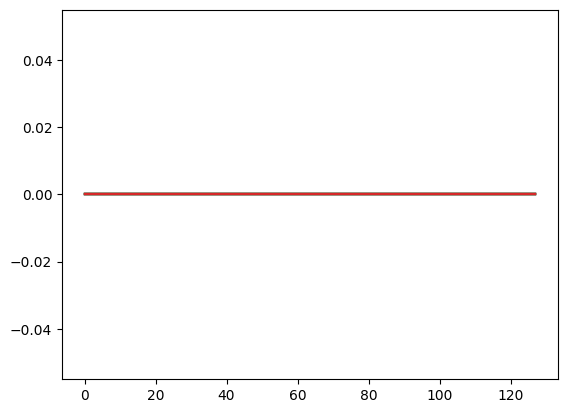

In [11]:
transcription = pretty_midi.PrettyMIDI(midis[0])
for note in transcription.instruments[0].notes:
    print(note.end-note.start)
plt.plot(transcription.get_piano_roll(1))

In [12]:
def load_audio(path):
    audio_tensors = []
    waveform, _ = torchaudio.load(path)
    return waveform

def load_roll(path, frames):
    transcription = pretty_midi.PrettyMIDI(path)
    roll = turn_transcription_into_roll(transcription, frames)

    return torch.from_numpy(roll).float()


# SISNR

In [13]:
def separate_sources(
    model,
    mix,
    drumroll,
    segment=4.0,
    overlap=0,
    device=None,
    sample_rate=44100,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        roll = drumroll[:, :, start:end]
        # print(torch.max(roll))
    
        with torch.no_grad():
            out = model.forward(chunk, roll)
        # print(out.shape)
        out = fade(out)
        # print(out.shape)
        try:
            final[:, :, start:end] += out
        except:
            pass
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final

In [14]:
class AudioData:
    def __init__(self, audio):
        self.audio = audio

In [15]:
name = 'epoch_200'
#try:
out_dir = f"D:/Github/phd-drum-sep/model-as-adt/results_conv_{name}/"
try:
    os.mkdir(out_dir)
except:
    pass

model = DrumConvTasnet.load_from_checkpoint(f'D:/Github/phd-drum-sep/analysis/conv_tasnet_model_analysis/checkpoint/{name}.ckpt')
# model.to('cpu')
model = model.eval()

results = museval.EvalStore(frames_agg='median', tracks_agg='median')
for track in tqdm(all_tracks):

    mixture_tensor = load_audio(track.mix_path).unsqueeze(0).to(model.device)
    print(mixture_tensor.shape)
    drum_tensor = load_audio(track.drum_path).unsqueeze(0).to(model.device)
    print(drum_tensor.shape)
    
    shape = mixture_tensor.shape[2]
    roll_tensor = load_roll(track.midi_path, shape).unsqueeze(0).to(model.device)

    seperated = separate_sources(model, mixture_tensor, roll_tensor, device='cuda')

    output_path = out_dir
    
    audio = seperated[:,0,:].cpu().numpy()
    audio = np.swapaxes(audio,0,1)

    audio2 = seperated[:,1,:].cpu().numpy()
    audio2 = np.swapaxes(audio2,0,1)

    audio3 = (seperated[:,1,:] + seperated[:,0,:]) / 2
    audio3 = audio3.cpu().numpy()
    audio3 = np.swapaxes(audio3, 0, 1)

    estimates = {'drums': audio, 'bass': audio2, 'mean': audio3}

    d = drum_tensor.squeeze(0).cpu().numpy()
    d = np.swapaxes(d,0,1)
    
    track.targets['drums'] = AudioData(d)
    track.targets['bass'] = AudioData(d)
    track.targets['mean'] = AudioData(d)
    
    scores = museval.eval_mus_track(
        track, estimates, output_dir=f"{output_path}"
    )

    print(scores)
    results.add_track(scores)

results.df.to_csv(f"{output_path}results.csv")

del model
gc.collect()


C:\Python311\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.2
  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

torch.Size([1, 2, 1628160])
torch.Size([1, 1, 1628160])


  4%|███▌                                                                               | 1/23 [00:10<03:41, 10.08s/it]

drums           ==> SDR:  -1.477  SIR: 215.466  ISR:  -0.627  SAR:  -2.790  
bass            ==> SDR:  -1.694  SIR: 219.542  ISR:  -0.763  SAR:  -2.676  
mean            ==> SDR:  -1.584  SIR: 227.633  ISR:  -0.694  SAR:  -2.732  

torch.Size([1, 2, 1604072])
torch.Size([1, 1, 1604072])


  9%|███████▏                                                                           | 2/23 [00:16<02:51,  8.15s/it]

drums           ==> SDR:  -4.518  SIR: 153.382  ISR:  -2.870  SAR:   4.104  
bass            ==> SDR:  -5.166  SIR: 152.133  ISR:  -3.553  SAR:   4.068  
mean            ==> SDR:  -4.830  SIR: 152.725  ISR:  -3.214  SAR:   4.110  

torch.Size([1, 2, 4540496])
torch.Size([1, 1, 4540496])


 13%|██████████▊                                                                        | 3/23 [00:35<04:18, 12.93s/it]

drums           ==> SDR:  -1.508  SIR: 209.640  ISR:   0.873  SAR: -15.324  
bass            ==> SDR:  -1.316  SIR: 211.547  ISR:   0.935  SAR: -14.302  
mean            ==> SDR:  -1.284  SIR: 209.374  ISR:   0.904  SAR: -14.677  

torch.Size([1, 2, 1622389])
torch.Size([1, 1, 1622389])


 17%|██████████████▍                                                                    | 4/23 [00:42<03:19, 10.50s/it]

drums           ==> SDR:  -1.412  SIR: 246.024  ISR:  -0.736  SAR:   0.469  
bass            ==> SDR:  -1.530  SIR: 244.598  ISR:  -0.797  SAR:   0.478  
mean            ==> SDR:  -1.469  SIR: 255.867  ISR:  -0.766  SAR:   0.504  

torch.Size([1, 2, 4478906])
torch.Size([1, 1, 4478906])


 22%|██████████████████                                                                 | 5/23 [01:00<04:01, 13.41s/it]

drums           ==> SDR:  -4.425  SIR: 249.316  ISR:   0.331  SAR: -10.817  
bass            ==> SDR:  -4.072  SIR: 249.187  ISR:   0.330  SAR:  -8.936  
mean            ==> SDR:  -4.093  SIR: 247.789  ISR:   0.342  SAR:  -9.657  

torch.Size([1, 2, 1532160])
torch.Size([1, 1, 1532160])


 26%|█████████████████████▋                                                             | 6/23 [01:06<03:05, 10.94s/it]

drums           ==> SDR: -15.000  SIR: 246.092  ISR: -13.269  SAR:   3.526  
bass            ==> SDR: -15.692  SIR: 249.640  ISR: -13.997  SAR:   3.487  
mean            ==> SDR: -15.349  SIR: 244.375  ISR: -13.640  SAR:   3.516  

torch.Size([1, 2, 5502796])
torch.Size([1, 1, 5502796])


 30%|█████████████████████████▎                                                         | 7/23 [01:27<03:47, 14.21s/it]

drums           ==> SDR:  -7.554  SIR: 250.168  ISR:  -5.065  SAR:   1.400  
bass            ==> SDR:  -8.159  SIR: 242.961  ISR:  -5.631  SAR:   1.418  
mean            ==> SDR:  -7.855  SIR: 239.727  ISR:  -5.350  SAR:   1.421  

torch.Size([1, 2, 4600605])
torch.Size([1, 1, 4600605])


 35%|████████████████████████████▊                                                      | 8/23 [01:46<03:53, 15.58s/it]

drums           ==> SDR:  -7.641  SIR: 229.892  ISR:  -0.159  SAR: -17.238  
bass            ==> SDR:  -4.801  SIR: 225.976  ISR:  -0.308  SAR: -12.289  
mean            ==> SDR:  -5.828  SIR: 229.286  ISR:  -0.226  SAR: -14.344  

torch.Size([1, 2, 2177937])
torch.Size([1, 1, 2177937])


 39%|████████████████████████████████▍                                                  | 9/23 [01:56<03:12, 13.75s/it]

drums           ==> SDR:   3.561  SIR: 261.595  ISR:   4.931  SAR:   2.650  
bass            ==> SDR:   3.771  SIR: 254.782  ISR:   5.455  SAR:   2.980  
mean            ==> SDR:   3.696  SIR: 255.539  ISR:   5.195  SAR:   2.921  

torch.Size([1, 2, 4894465])
torch.Size([1, 1, 4894465])


 43%|███████████████████████████████████▋                                              | 10/23 [02:16<03:25, 15.79s/it]

drums           ==> SDR:   1.853  SIR: 235.976  ISR:   4.559  SAR:   2.927  
bass            ==> SDR:   1.829  SIR: 242.706  ISR:   4.558  SAR:   3.155  
mean            ==> SDR:   1.956  SIR: 252.177  ISR:   4.568  SAR:   3.196  

torch.Size([1, 2, 3340015])
torch.Size([1, 1, 3340015])


 48%|███████████████████████████████████████▏                                          | 11/23 [02:28<02:55, 14.64s/it]

drums           ==> SDR:  -4.784  SIR: 257.886  ISR:  -0.391  SAR:  -1.168  
bass            ==> SDR:  -5.452  SIR: 260.409  ISR:  -0.886  SAR:  -1.137  
mean            ==> SDR:  -5.128  SIR: 249.539  ISR:  -0.637  SAR:  -1.151  

torch.Size([1, 2, 1845768])
torch.Size([1, 1, 1845768])


 52%|██████████████████████████████████████████▊                                       | 12/23 [02:35<02:15, 12.28s/it]

drums           ==> SDR:  -9.735  SIR: 249.545  ISR:  -7.734  SAR:   0.820  
bass            ==> SDR: -10.299  SIR: 248.816  ISR:  -8.218  SAR:   0.836  
mean            ==> SDR: -10.018  SIR: 234.330  ISR:  -7.970  SAR:   0.834  

torch.Size([1, 2, 875118])
torch.Size([1, 1, 875118])


 57%|██████████████████████████████████████████████▎                                   | 13/23 [02:39<01:36,  9.66s/it]

drums           ==> SDR:  -1.275  SIR: 110.349  ISR:  -0.749  SAR:   0.663  
bass            ==> SDR:  -1.432  SIR: 110.918  ISR:  -0.851  SAR:   0.730  
mean            ==> SDR:  -1.352  SIR: 110.505  ISR:  -0.799  SAR:   0.700  

torch.Size([1, 2, 2953192])
torch.Size([1, 1, 2953192])


 61%|█████████████████████████████████████████████████▉                                | 14/23 [02:50<01:30, 10.05s/it]

drums           ==> SDR:   0.746  SIR: 250.884  ISR:   0.861  SAR:  -0.888  
bass            ==> SDR:   0.805  SIR: 248.561  ISR:   0.941  SAR:  -0.981  
mean            ==> SDR:   0.782  SIR: 252.408  ISR:   0.901  SAR:  -0.856  

torch.Size([1, 2, 4576639])
torch.Size([1, 1, 4576639])


 65%|█████████████████████████████████████████████████████▍                            | 15/23 [03:09<01:42, 12.78s/it]

drums           ==> SDR:   1.784  SIR: 245.921  ISR:   4.052  SAR:  -0.780  
bass            ==> SDR:   1.706  SIR: 241.163  ISR:   4.342  SAR:  -0.865  
mean            ==> SDR:   1.865  SIR: 246.812  ISR:   4.197  SAR:  -0.660  

torch.Size([1, 2, 1268428])
torch.Size([1, 1, 1268428])


 70%|█████████████████████████████████████████████████████████                         | 16/23 [03:15<01:16, 10.89s/it]

drums           ==> SDR:  -6.063  SIR: 246.764  ISR:  -2.785  SAR:  -1.080  
bass            ==> SDR:  -6.658  SIR: 246.621  ISR:  -3.123  SAR:  -1.173  
mean            ==> SDR:  -6.348  SIR: 236.594  ISR:  -2.953  SAR:  -1.092  

torch.Size([1, 2, 770104])
torch.Size([1, 1, 770104])


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [03:19<00:52,  8.73s/it]

drums           ==> SDR:  -4.405  SIR: 155.838  ISR:  -3.735  SAR:   5.603  
bass            ==> SDR:  -5.120  SIR: 159.218  ISR:  -4.421  SAR:   5.765  
mean            ==> SDR:  -4.754  SIR: 158.714  ISR:  -4.080  SAR:   5.811  

torch.Size([1, 2, 1144358])
torch.Size([1, 1, 1144358])


 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [03:24<00:38,  7.60s/it]

drums           ==> SDR: -11.226  SIR: 180.633  ISR:  -7.368  SAR:  -0.298  
bass            ==> SDR: -11.928  SIR: 183.383  ISR:  -8.010  SAR:  -0.359  
mean            ==> SDR: -11.576  SIR: 181.177  ISR:  -7.693  SAR:  -0.320  

torch.Size([1, 2, 577320])
torch.Size([1, 1, 577320])


 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [03:27<00:24,  6.16s/it]

drums           ==> SDR:  -5.384  SIR: 164.601  ISR:  -1.879  SAR:   0.653  
bass            ==> SDR:  -6.026  SIR: 164.078  ISR:  -2.479  SAR:   0.627  
mean            ==> SDR:  -5.701  SIR: 163.442  ISR:  -2.180  SAR:   0.659  

torch.Size([1, 2, 1476953])
torch.Size([1, 1, 1476953])


 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [03:33<00:18,  6.25s/it]

drums           ==> SDR:   3.232  SIR: 178.752  ISR:   5.710  SAR:   4.035  
bass            ==> SDR:   3.377  SIR: 183.709  ISR:   6.045  SAR:   4.357  
mean            ==> SDR:   3.376  SIR: 180.542  ISR:   5.887  SAR:   4.299  

torch.Size([1, 2, 1587968])
torch.Size([1, 1, 1587968])


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [03:40<00:12,  6.31s/it]

drums           ==> SDR:  -1.590  SIR: 242.157  ISR:   0.136  SAR:   2.242  
bass            ==> SDR:  -2.033  SIR: 256.215  ISR:  -0.117  SAR:   2.379  
mean            ==> SDR:  -1.797  SIR: 257.720  ISR:   0.016  SAR:   2.370  

torch.Size([1, 2, 3947520])
torch.Size([1, 1, 3947520])


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [03:55<00:09,  9.01s/it]

drums           ==> SDR:   1.299  SIR: 247.855  ISR:   6.876  SAR:   0.293  
bass            ==> SDR:   1.561  SIR: 248.445  ISR:   7.241  SAR:   0.666  
mean            ==> SDR:   1.526  SIR: 250.844  ISR:   7.047  SAR:   0.468  

torch.Size([1, 2, 770649])
torch.Size([1, 1, 770649])


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [04:01<00:00, 10.50s/it]

drums           ==> SDR:   2.470  SIR: 152.249  ISR:   2.465  SAR:   4.599  
bass            ==> SDR:   2.706  SIR: 152.726  ISR:   2.727  SAR:   4.603  
mean            ==> SDR:   2.596  SIR: 152.184  ISR:   2.595  SAR:   4.697  



177

In [16]:
results.agg_frames_tracks_scores(), 

(target  metric
 bass    ISR        -0.763295
         SAR         0.665770
         SDR        -2.033110
         SIR       242.706060
 drums   ISR        -0.391020
         SAR         0.653390
         SDR        -1.590200
         SIR       242.157360
 mean    ISR        -0.636810
         SAR         0.658920
         SDR        -1.797345
         SIR       236.594285
 Name: score, dtype: float64,)

In [17]:
r = results.agg_frames_scores().to_dict()

In [18]:
sdrs = []
for key in list(r.keys()):
    if 'SDR' in key:
        sdrs.append(r[key])

print(np.median(sdrs))

-1.797345
